# Computing mean termination time for a powerlaw fit
 Tim Tyree<br>
 9.7.2021

In [2]:
from lib.my_initialization import *
from lib import *
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [11]:
#reset matplotlib settings
from mpltools import annotation
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# # For darkmode plots
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

__Introduction__

Suppose we have a death process between randomly moving particles that are attracted to one another.

Simpler: 
Suppose we have a death process defined over the positive even integers, $\Omega={0,2,4,...}$.  The rate of the process $N\rightarrow N-2$ is denoted as $W_{-2}(N)$  we observe the approximately scale invarient solution numerically identified previously (CITE: Vidmar \& Rappel,2019), $w=W_{-2}(N)/A~f(q)=f(N/A)$.   From their data we have deduced a concave powerlaw relationship,

$$w=W_{-2}(N)/A=Mq^\nu=M(N/A)^\nu$$



__Computing the mean termination time (MTT) of an annihilation process with decay rates scaling with some powerlaw dependence on N/A__
- DONE: plot tau(2) as grayscale over M versus nu
- DONE: plot tau(2) as grayscale over M versus nu_new, which is built to work with PM's forceless model, where nu=2... here $\nu_{new}=2-\nu$
- DONE: plot plot tau(4),tau(6),tau(8) as grayscale over M versus nu
- DONE: plot tau(2) on a versus r using the interpolating function that maps ($a$,$r$),$\kappa=500$ Hz, $D=2$ cm$^2/s$ $\longrightarrow (M,\nu) \longrightarrow$ MTT.


# dev map $(M,\nu) \longrightarrow$ the mean termination time conditioned on two particles that annihilate

Sketch of proof that MTT2$ =\tau(2)$ = the mean termination time conditioned on two particles 
$$
\tau(2)=1/W_{-2}(N=2)=1/(w(q=2/A)A)=1/(AM(2/A)^\nu)
$$

It can be shown that
$$
\tau(2)=2^{-\nu}A^{\nu-1}M^{-1}
$$

For $A=25$ cm$^2$, we have
$$
\tau(2)=2^{-\nu}(25 cm^2)^{\nu-1}M^{-1}
$$

For N>2, we can solve by adding the rates as capacitors in series:

$$
\tau(N) = \frac{1}{W_{-2}(2)} + \frac{1}{W_{-2}(4)} + ... \frac{1}{W_{-2}(N)}
$$

Factoring by $\tau(2)$, we arrive at the following formula for $\tau(N)$:

$$
\tau(N) = \tau(2)\sum_{j=1}^{\lfloor N/2\rfloor} j^{-\nu}
$$

In [4]:
def comp_tau2(M,nu,A=25.):
    '''the mean termination time from the 2->0 process, with powerlaw distributed annihilation rates'''
    tau2=2**-nu * A**(nu-1) * M
    return tau2

def comp_tau(N,M,nu,A=25.):
    '''the mean termination time from the N->0 process, with powerlaw distributed annihilation rates'''
    kmax=int(N/2)
    tau2=comp_tau2(M,nu,A)
    ktot=0.
    for k in range(kmax):
        ktot = ktot + (k+1)**-nu
    return tau2*ktot  

In [5]:
#test that the N=2 value maps to tau2 as it should
assert ( comp_tau(N=2,M=15,nu=2,A=25.)==comp_tau2(M=15,nu=2,A=25.) ) 

In [7]:
wjr=recall_powerlaw_fits_to_full_models()
model_name='fk_pbc'
print(model_name)
#some exampels
for j in range(3):
    k=2*(j+1)
    print(f"tau({k})={comp_tau(N=k,M=wjr[model_name]['M'],nu=wjr[model_name]['m'],A=25.)/60:.2f} minutes")
 
print('')
model_name='lr_pbc'
print(model_name)
#some exampels
for j in range(3):
    k=2*(j+1)
    print(f"tau({k})={comp_tau(N=k,M=wjr[model_name]['M'],nu=wjr[model_name]['m'],A=25.)/60:.2f} minutes")

fk_pbc
tau(2)=0.43 minutes
tau(4)=0.54 minutes
tau(6)=0.60 minutes

lr_pbc
tau(2)=0.70 minutes
tau(4)=0.92 minutes
tau(6)=1.04 minutes


In [18]:
def PlotMTTAnnihilationOnly(fig,ax,N=2,A=25,show_cbar=True,use_cbar=True,use_legend=True,**kwargs):
    '''
    N=positive even integer representing the initial number of particles
    A=25#cm^2= area of computational domain 
    '''
    #define pixel locations
    M_values=np.linspace(0,30,101)#199)#<3
    nu_values=np.linspace(0,3,101)#100)

    #TODO: plot the FK and LR model scattered on this with uncertainty bars
    errkwargs={
        'alpha':.7,
        'fmt':'o',
        'markersize':2,
        'elinewidth':3,
        'errorevery':1,
        'capsize':3
    }
    wjr=recall_powerlaw_fits_to_full_models()


    #compute the data
    XI=np.meshgrid(*(M_values,nu_values))
    x1_values=XI[0]
    x2_values=XI[1]
    y_values=comp_tau(N,x1_values,x2_values,A)/60 #minutes

    fontsize=20
    vmin=0#np.min(y_values)
    vmax=1#np.max(y_values)
    clabel=r'mean termination'+f'\n'+f'time (min) for {N:d}'+r'$\rightarrow0$'
    cmap='gray'
    # cmap='Reds'
    x1label=r'$M$ (cm$^{2(\nu-1)}/$s)'
    x2label=r'$\nu$'
    title=f'Area of domain = {A:d} cm'+r'$^2$'
    x1lim=(np.min(x1_values),np.max(x1_values))
    x2lim=(np.min(x2_values),np.max(x2_values))

    #plot the grayscale background and format plot
    PlotInterpolatedBackground(fig,ax,x1_values,x2_values,y_values,vmin,vmax,clabel,cmap,fontsize=fontsize,show_cbar=show_cbar,use_cbar=use_cbar,**kwargs)
    FormatAxes(ax=ax, x1label=x1label, x2label=x2label, title=title, x1lim=x1lim, x2lim=x2lim, fontsize=fontsize, use_loglog=False, **kwargs)

    #plot the power law fits for the full models
    model_name='fk_pbc'
    plt.errorbar(x   =[wjr[model_name]['M']]     , y=[wjr[model_name]['m']],
                 xerr=[wjr[model_name]['Delta_M']],yerr=[wjr[model_name]['Delta_m']],c='C0',ecolor='C0',label='Fenton-Karma model',**errkwargs)
    model_name='lr_pbc'
    ax.errorbar(x   =[wjr[model_name]['M']]     , y=[wjr[model_name]['m']],
                 xerr=[wjr[model_name]['Delta_M']],yerr=[wjr[model_name]['Delta_m']],c='C1',ecolor='C1',label='Luo-Rudy model',**errkwargs)
    
    ax.plot(M_values,2+0.*M_values,'k--',alpha=0.3,lw=3)
    if use_legend:
        ax.legend(fontsize=fontsize-8)
    return True

In [19]:
FormatAxes

<function lib.viewer.bluf.plot_func.FormatAxes(ax, x1label, x2label, title=None, x1lim=None, x2lim=None, fontsize=16, use_loglog=False, **kwargs)>

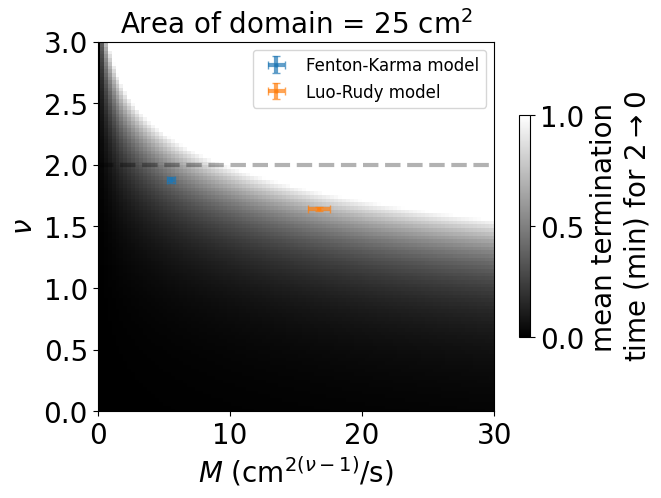

In [20]:
#DONE: redo ^that plot for 4->0 and 6->0 with A=25 cm^2 fixed
#DONE: redo at least one of ^those plots (2->0)  for A=50 and A=100cm^2 
#DONE: rerun this notebook with darkmode turned off.  collect screenshots into a .pdf for today's meeting.
fig,ax=plt.subplots(1)
PlotMTTAnnihilationOnly(fig=fig,ax=ax,N=2,A=25)
plt.show()

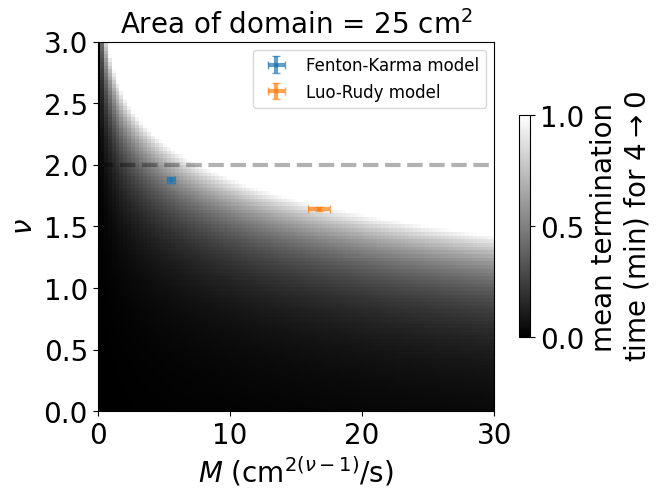

In [21]:
# fig,axs=plt.subplots(ncols=3,figsize=(12,4))
# PlotMTTAnnihilationOnly(fig,axs[0],N=2,A=25,show_cbar=False,use_cbar=False,use_legend=False)
# PlotMTTAnnihilationOnly(fig,axs[1],N=4,A=25,show_cbar=False,use_cbar=False,use_legend=False)
# PlotMTTAnnihilationOnly(fig,axs[2],N=6,A=25,show_cbar=False,use_cbar=False,use_legend=False)
# plt.tight_layout()
# fig.show()

fig,ax=plt.subplots(1)
PlotMTTAnnihilationOnly(fig,ax,N=4,A=25)
plt.show()

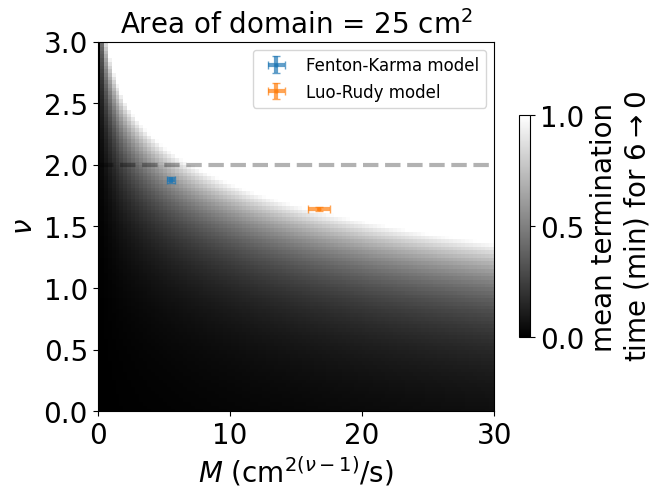

In [22]:
fig,ax=plt.subplots(1)
PlotMTTAnnihilationOnly(fig,ax,N=6,A=25)
plt.show()

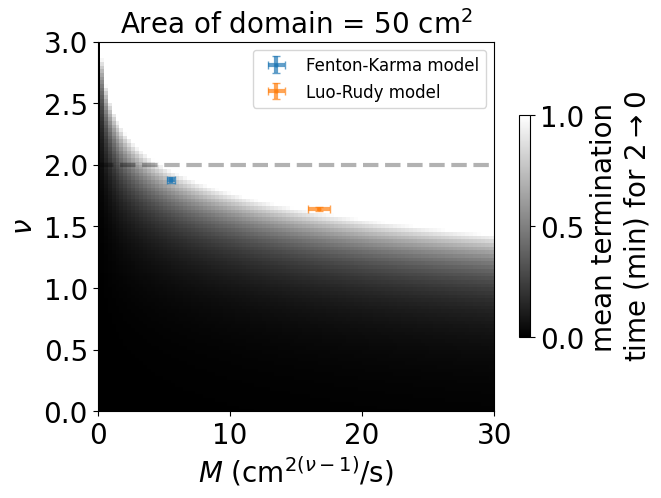

In [23]:
fig,ax=plt.subplots(1)
PlotMTTAnnihilationOnly(fig,ax,N=2,A=50)
plt.show()

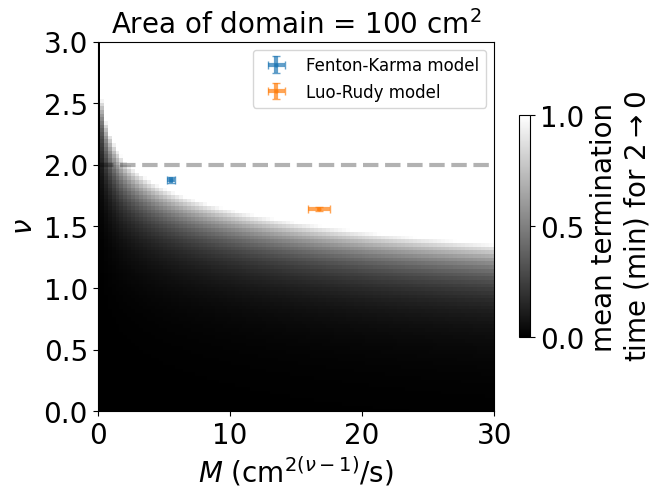

In [24]:
fig,ax=plt.subplots(1)
PlotMTTAnnihilationOnly(fig,ax,N=2,A=100)
plt.show()

In [25]:
wjr=recall_powerlaw_fits_to_full_models()
model_name='fk_pbc'
print(model_name)
#some exampels
for A in [25,50,100]:
    print(f"for A={A:.0f} cm^2, tau({k})={comp_tau(N=2,M=wjr[model_name]['M'],nu=wjr[model_name]['m'],A=A)/60:.2f} minutes")
 
print('')
model_name='lr_pbc'
print(model_name)
#some exampels
for A in [25,50,100]:
    print(f"for A={A:.0f} cm^2, tau({k})={comp_tau(N=2,M=wjr[model_name]['M'],nu=wjr[model_name]['m'],A=A)/60:.2f} minutes")
        

fk_pbc
for A=25 cm^2, tau(6)=0.43 minutes
for A=50 cm^2, tau(6)=0.78 minutes
for A=100 cm^2, tau(6)=1.44 minutes

lr_pbc
for A=25 cm^2, tau(6)=0.70 minutes
for A=50 cm^2, tau(6)=1.09 minutes
for A=100 cm^2, tau(6)=1.69 minutes


__Next Steps: Including Birth Rates__  See iPad pen & paper work/notes...  The nested infinite sum is computable for the sake of making plots and such.  The following absolutely converging Dirichlet series keeps appearing though...

For powerlaw creation rates,
$w_+(q) = W_{+2}(N)/A = M_+(N/A)^{\nu_+}$
and annihilation rates,
$w_-(q) = W_{-2}(N)/A = M_-(N/A)^{\nu_-}$

we may substitute into Eqn. 8 (Vidmar & Rappel, 2019) to analytically compute the mean termination time conditioned on $N$ tips initially being present.

$$
\tau(N) = M_+^{-1}(A/2)^{\nu_+} \sum_{k=1}^{\lfloor N/2\rfloor} x^{1-k}(k-1)! \sum_{j=k}^\infty Q_k(x,\beta,\nu_+)
$$
where we have defined the constant parameters, $\beta=\nu_--\nu_+$ and $x=\frac{M_+}{M_-}(\frac{A}{2})^\beta$, and we have defined the function $Q_k = Q_k(x,\beta,\nu_+)$
$$
Q_k =  \sum_{j=k}^\infty \frac{x^j j^{-s}}{j!^\beta}
$$

Plugging in $N=2$, we find $\tau(2)=M_+^{-1}(A/2)^{\nu_+} Q_1$, which involves the Dirichlet series in $s=\nu_+$ which is absolutely convergent:

$$
Q_1 = \sum_{j=1}^\infty \frac{x^j}{j!^\beta j^{s}}
$$

Computing higher orders of $\tau(N)$ is straightforward after the evaluation of $Q_{k=1}$. 

For the full models we expect the following real parameters:

At high densities, where $N/A>0.1$ per square centimeter, we expect the following parameter values for $A = 25 cm^2$:
<table>
  <tr>
    <th>model</th>
    <th>$s$</th>
    <th>$\beta$</th>
    <th>$x$</th>
  </tr>
  <tr>
    <td>Fenton-Karma</td>
    <td>0.197(7)</td>
    <td>1.68(3)</td>
    <th>$\approx12.2$</th>
  </tr>
  <tr>
    <td>Luo-Rudy</td>
    <td>0.65(2)</td>
    <td>0.93(3)</td>
    <th>$\approx1.3$</th>
  </tr>
</table>

In [26]:
wjr=recall_powerlaw_fits_to_full_models()

In [27]:
A=25 #cm^2
# x=\frac{M_+}{M_-}(\frac{A}{2})^\beta$
#calc x for FK
beta=1.88-.197
Delta_beta=np.sqrt(0.03**2+0.007**2)
print((beta,Delta_beta))

#Mplus for FK model
Mplus,Delta_Mplus=comp_power_scale(B=np.exp(-0.1568262933553215), Delta_B=np.exp(0.008869706927806541), m=0.19687022603831317, Delta_m=0.007054990756244542)
print((Mplus,Delta_Mplus))
Mminus=wjr['fk_pbc']['M']
Delta_Mminus=wjr['fk_pbc']['Delta_M']

#TODO: compute uncertainty estimate in x
x=(Mplus/Mminus)*(A/2)**beta
x

(1.6829999999999998, 0.030805843601498725)
(0.9695973198794758, nan)


/Users/timothytyree/Documents/GitHub/bgmc/python/lib/measure/powerlaw.py:10: RuntimeWarning: invalid value encountered in double_scalars
  min_bound=(B-Delta_B)**(m-Delta_m)


12.208301515908579

In [91]:
# x=\frac{M_+}{M_-}(\frac{A}{2})^\beta$
#calc x for LR
beta=1.58-.65
Delta_beta=np.sqrt(0.02**2+0.02**2)
print((beta,Delta_beta))

#Mplus for LR model
Mplus,Delta_Mplus=comp_power_scale(B=np.exp(1.1263098384848962), Delta_B=np.exp(0.02645979865782054), m=0.6522802834907268, Delta_m=0.016231149413306015)
print((Mplus,Delta_Mplus))


#Mplus for FK model
Mminus=wjr['lr_pbc']['M']
Delta_Mminus=wjr['lr_pbc']['Delta_M']

#TODO: compute uncertainty estimate in x
x=(Mplus/Mminus)*(A/2)**beta
x

(0.93, 0.0282842712474619)
(2.0847932731052743, 0.502483064106906)


1.3048123503058182

In [76]:
from inspect import getsource
print(getsource(comp_power_scale))

def comp_power_scale(B,Delta_B,m,Delta_m):
    '''compute pessemistic 95% CI of annihilation rate scale, M_fk=B_fk**m_fk'''
    #min bound
    min_bound=(B-Delta_B)**(m-Delta_m)
    # print(B**m-min_bound)
    #max bound
    max_bound=(B+Delta_B)**(m+Delta_m)
    # print(max_bound-B**m)
    Delta_M=np.max((max_bound-B**m,B**m-min_bound))
    M=B**m
    return M,Delta_M



In [77]:
-0.1**.2

-0.6309573444801932

In [81]:
(-.15)**.1968

(0.5609848381063952+0.3990249405386927j)

In [96]:
A=25 #cm^2
#computing tau(2)
#from mathematica, for FK
Q1=98.8398
#Mplus for FK model
Mplus,Delta_Mplus=comp_power_scale(B=np.exp(-0.1568262933553215), Delta_B=np.exp(0.008869706927806541), m=0.19687022603831317, Delta_m=0.007054990756244542)
tau2=1/Mplus*(A/2)**0.19687022603831317*Q1
print(f"tau(2)={tau2/60:.2f} minutes for the FK model")

#from mathematica, for LR
Q1=2.14817
# Mplus for LR model
Mplus,Delta_Mplus=comp_power_scale(B=np.exp(1.1263098384848962), Delta_B=np.exp(0.02645979865782054), m=0.6522802834907268, Delta_m=0.016231149413306015)
tau2=1/Mplus*(A/2)**0.6522802834907268*Q1
print(f"tau(2)={tau2/60:.2f} minutes for the LR model")


tau(2)=2.79 minutes for the FK model
tau(2)=0.09 minutes for the LR model


__Nota bene:__ adding creation should _increase_ tau(2), but this isn't the case for the Luo-Rudy model...

Maybe you could help me/offer me some advice on this.  Last night, I was trying to compute the mean termination time for powerlaw birth/death rates using the analytic equations in Vidma & Rappel (2019), and I keep running into an infinite series of the form
$$Q(x,\beta,s) = \sum_{n=1}^\infty \frac{x^n}{(n!)^\beta n^s}$$

This is a Dirichlet series that converges absolutely, I believe.  Also, we can assume $x$, $\beta$ and $s$ are all strictly positive real numbers that have observable values that I can compute for the Fenton-Karma model and for the Luo-Rudy models.  The numerical sum converges very quickly, which leads me to believe a simplified form exists in terms of special functions. However, I couldn't find something like Q in this table (http://www-elsa.physik.uni-bonn.de/~dieckman/InfProd/InfProd.html) or by plugging it into Mathematica...  Maybe Weierstrass's definition of the Euler Gamma function would help in analytically evaluating $(n!)^\beta$...  Maybe Dirichlet convolution could be used to break Q up into two Dirichlet infinite series that have already been solved in close form...

# TODO: consider using Monte Carlo to solve MTT 
- for the pbc case ( only pair creation / annihilation )
- for the pbc case with arbitrary input powerlaw fits, m,M
- for the nonconducting boundary condition case

In [6]:
from lib import *
ncbc=recall_ncbc_powerlaw_fits()


NameError: name 'recall_ncbc_powerlaw_fits' is not defined

In [ ]:
wjr=recall_powerlaw_fits_to_full_models()

wjr

In [1]:
1

1